# The Eaton and Palisades Fire
## Exploring the extent and impact of the Eaton and Palisades fire in Los Angeles County

![](fire.jpg)

## Background
The Eaton and Palisades fire in Los Angeles County were devastating for local communities, damaging thousands of homes and many acres of ecological habitat, leaving deep scars in both the communities they affected and the land itself. In this study, we will visualize the extents and impacts of the Eaton and Palisades fires using false color imagery through landsat data and known perimeters of both fires, and focus in on an environmental justice metric to assess the community's potential response to wildfire.

To learn more about false color images and landsats, see the following resources:

[Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image](https://earthobservatory.nasa.gov/features/FalseColor)

[What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

[Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)

### Analysis Highlights

In this study, we will highlight the following skills:

1.  Examining rioxarrays and NetCDF files to pull, transform, and manipulate spatial data.
2.  Map true and false color images from NetCDF files.
3.  Map census tracts that intersect the Eaton and Palisades fire to explore potential injustices.

### Datasets:

Landsat data are from [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). These data contain bands for red, green, blue, near-infrared and shortwave infrared, from the Landsat Collection 2 Level-2 collected by Landsat-8. Our data is cropped to areas surrounding the extent of the fires.

Perimeter data are from [Los Angeles County Dissolved Fire Perimeter Data](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about). These data originate from data containing daily snapshots of perimeters, but are dissolved into one layer for these data.

Fire perimeter data: https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about Landsat data: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

EJI data are from the [Environmental Justice Index (EJI)](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html), a national tool to measure environmental burden. The EJI ranks tracts for 36 different factors developed from data from many different sources.

In [ ]:
# Load libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import contextily as ctx

In [3]:
# Load data

# Read in NetCDF file
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

# Read in perimeter data
eaton_perimeter = gpd.read_file('data/Eaton_Perimeter/Eaton_Perimeter_20250121.shp')
palisades_perimeter = gpd.read_file('data/Palisades_Perimeter/Palisades_Perimeter_20250121.shp')

# Import CA EJI gdb
fp = os.path.join("data", "EJI_2024_California", "EJI_2024_California.gdb")
eji_california = gpd.read_file(fp)

# Part 1: Visualize extent of fires using false color imagery

Check CRS of perimeter data and transform to match

In [6]:
print(palisades_perimeter.crs)
print(eaton_perimeter.crs)

# Update CRS to match the landsat data
palisades_perimeter = palisades_perimeter.to_crs('epsg:32611')
eaton_perimeter = eaton_perimeter.to_crs('epsg:32611')

EPSG:3857
EPSG:3857


Restore geospatial information to landsat data 

In [9]:
# Pull out the CRS information by accessing that attribute
landsat.spatial_ref.crs_wkt

# Assign the correct crs to the data
landsat.rio.write_crs(32611, inplace = True)

# Check crs is correctly applied
print(landsat.rio.crs)

EPSG:32611


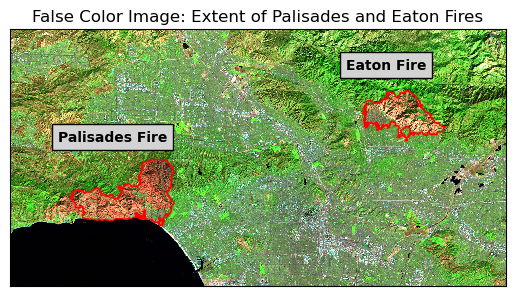

In [10]:
fig, ax = plt.subplots()

# Plot the false color landsat map
landsat[['swir22', 'nir08', 'red']].fillna(0).to_array().plot.imshow(robust = True)

# Plot perimeters overlayed on the false color map
palisades_perimeter.plot(ax=ax, color = 'none', edgecolor='red')
eaton_perimeter.plot(ax=ax, color = 'none', edgecolor='red')

# Set title
ax.set_title("False Color Image: Extent of Palisades and Eaton Fires")

# Add labels for each fire
plt.figtext(x = .65,
            y = .68,
            s ="Eaton Fire",
            weight = 'bold',
            bbox=dict(facecolor='lightgray', edgecolor='black'))
plt.figtext(x = .2,
            y = .53,
            s ="Palisades Fire",
            weight = 'bold',
            bbox=dict(facecolor='lightgray', edgecolor='black'))

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

plt.show()

Here we are visualizing landsat data from Los Angeles County, focusing on the areas encompassing the Palisades and Eaton fires from January 2025. This is a false color image, with short-wave infrared assigned to red, near-infrared assigned to blue, and red assigned to green. Short-wave infrared highlights recently burned areas, and near-infrared highlights areas of healthy vegetation. With this method, we are able to easily identify fire scars left behind from the large fires, identified by the red color on the map. Overlayed are known perimeters of each fire, and we can see the perimeters and scars identified by landsat are very similar.

Now we will dive deeper into the socioeconomic attributes of the communities affected by each fire.

# Part 2: Social dimensions of Eaton and Palisades fires

First some data cleaning to prepare the data for visualizing.

In [21]:
# Change crs back to original for mapping
palisades_perimeter = palisades_perimeter.to_crs('EPSG:3857')
eaton_perimeter = eaton_perimeter.to_crs('EPSG:3857')

# Transform crs of EJI data to match perimeter data, and join with perimeter data
eji_california = eji_california.to_crs(palisades_perimeter.crs)
eji_palisades = gpd.sjoin(eji_california, palisades_perimeter, predicate = 'intersects')

eji_california = eji_california.to_crs(eaton_perimeter.crs)
eji_eaton = gpd.sjoin(eji_california, eaton_perimeter, predicate = 'intersects')

In [22]:
# Clip census tract data to extents of perimeter data
eji_palisades_clipped = gpd.clip(eji_california, palisades_perimeter)
eji_eaton_clipped = gpd.clip(eji_california, eaton_perimeter)

Next we will visualize fire perimeters over a street map to see which areas of the city were affected.

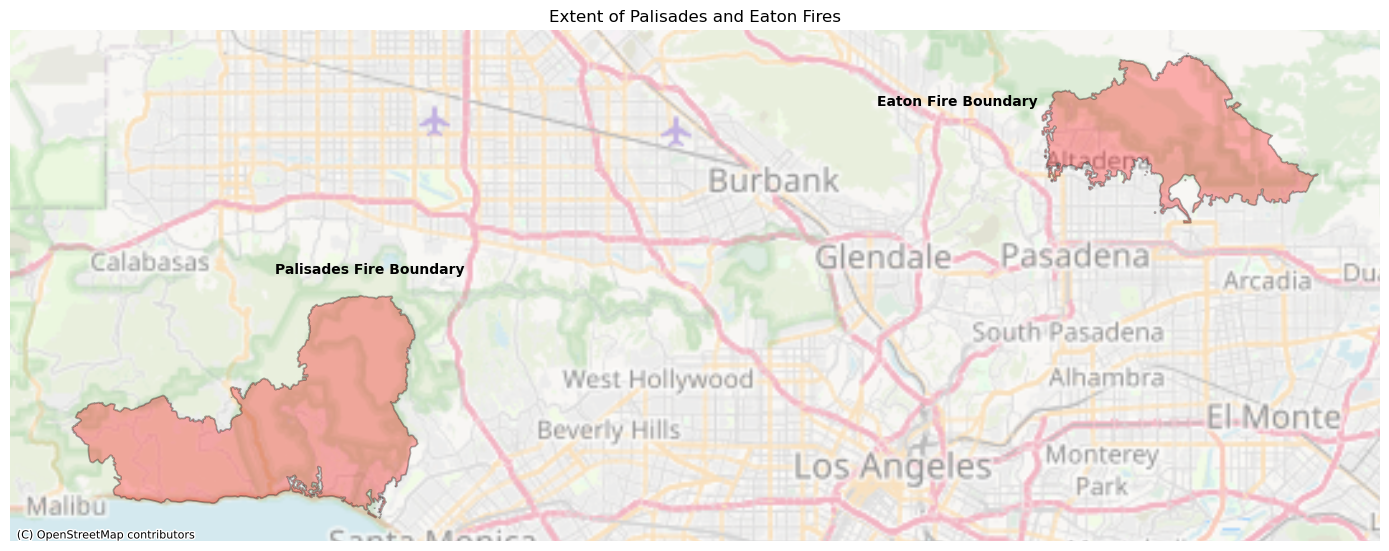

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR

palisades_perimeter.plot(ax=ax,
                       edgecolor = 'black',
                       color='red',
                       linewidth=1.25,
                       alpha=0.3)
eaton_perimeter.plot(ax=ax,
                   edgecolor = 'black',
                   color='red',
                   linewidth=1.25,
                   alpha=0.3)

# ADD LEGEND OR ANNOTATION TO IDENTIFY EACH FIRE
plt.figtext(x = .63,
            y = .65,
            s ="Eaton Fire Boundary",
            weight = 'bold')
plt.figtext(x = .2,
            y = .51,
            s ="Palisades Fire Boundary",
            weight = 'bold'
            )


# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.5)

# ADD TITLE
ax.set_title("Extent of Palisades and Eaton Fires")

ax.axis('off')

plt.tight_layout()
plt.show()

We can see the area of the Palisades fire is mostly out of the metropolitan areas of Los Angeles and into the more spread out, coastal area. The Eaton fire is also largely vegetation, but encompass areas of Altadena and some surrounding city.

Now we will look at census tracts for the percentage of persons who identify as a minority in each fire's affected area.

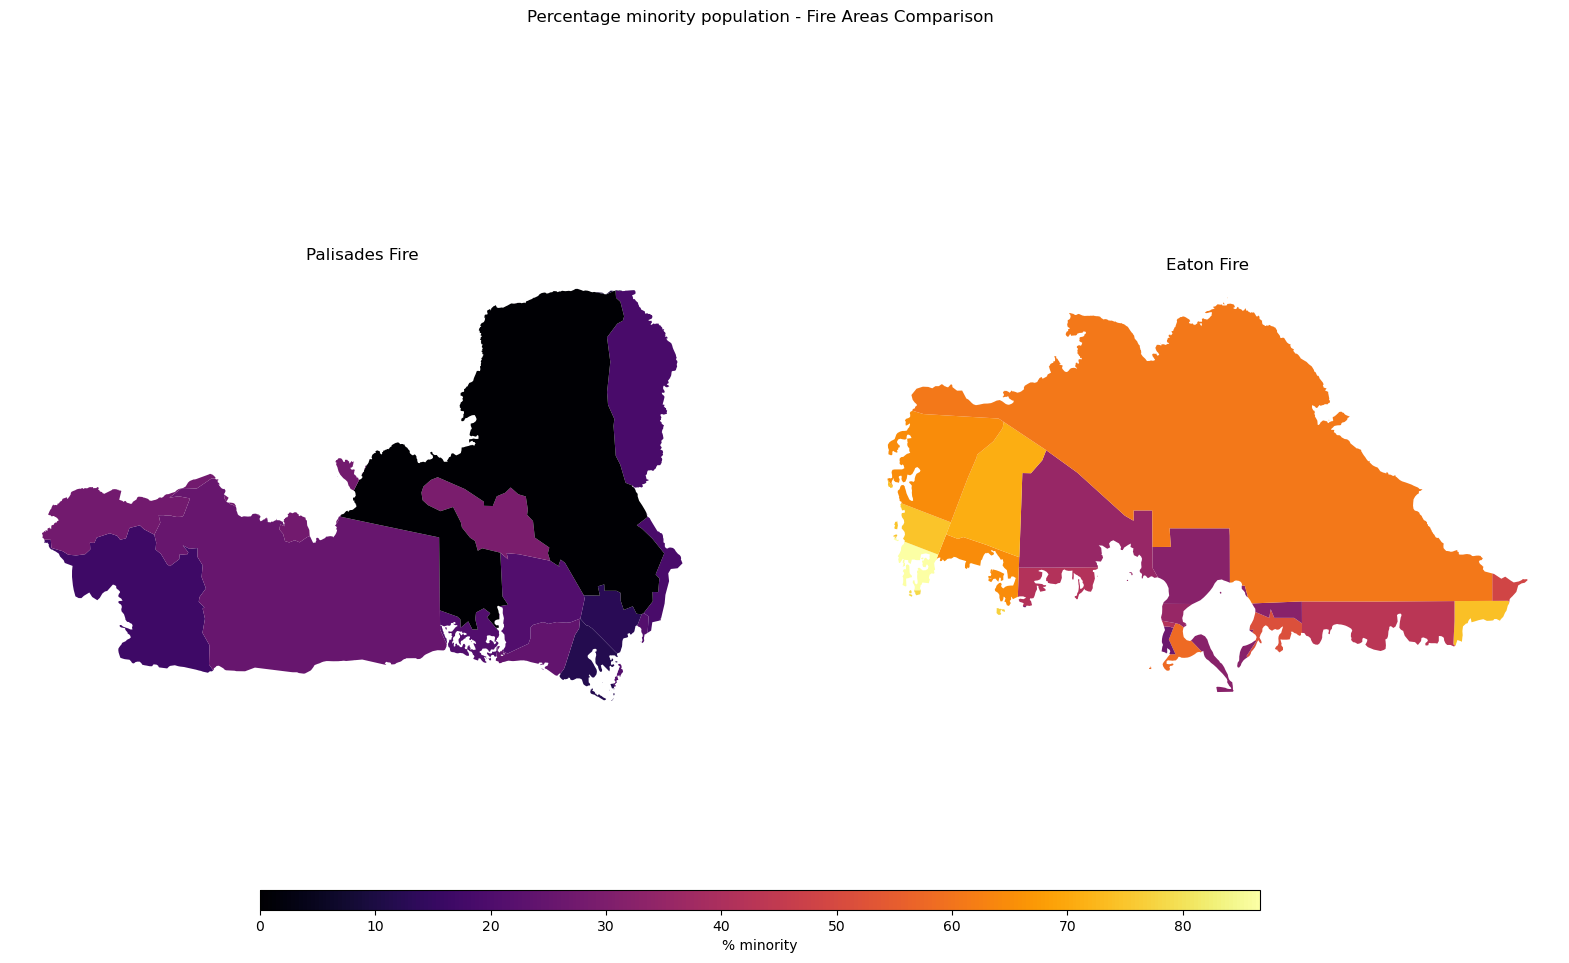

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'E_MINRTY'

# Find common min/max for legend range
vmin = min(eji_palisades_clipped[eji_variable].min(), eji_eaton_clipped[eji_variable].min())
vmax = max(eji_palisades_clipped[eji_variable].max(), eji_eaton_clipped[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_palisades_clipped.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap = 'inferno'
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eaton_clipped.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap = 'inferno'
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Percentage minority population - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap = 'inferno')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('% minority')

plt.show()

Despite its smaller acreage, we can clearly see that the Eaton fire disproportionately affected an area with a much higher minority population than the Palisades fire. Through these visualizations, we can begin to explain a potential pattern of environmental injustice in this area of Los Angeles that may become exacerbated with the increase in natural disasters caused by climate change.